<a href="https://colab.research.google.com/github/morganmcg1/reformer-fastai/blob/main/exploration/reformer_w_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# credits to @lucidrains https://github.com/lucidrains

In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip install -qq einops axial-positional-embedding

In [3]:
import math
import torch
from torch import nn, einsum
import torch.nn.functional as F
from functools import partial, reduce
from inspect import isfunction
from operator import mul

from einops import rearrange, repeat

import pdb

## Basic Code

In [4]:
# credits to @lucidrains https://github.com/lucidrains

import torch
from torch import nn, einsum
import torch.nn.functional as F
from functools import partial, reduce
from inspect import isfunction
from operator import mul

from einops import rearrange, repeat
try:
    from axial_positional_embedding import AxialPositionalEmbedding, AxialPositionalEmbeddingImage
except ImportError as e:
    print(e)

# helpers

def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def expand_dim1(x):
    if len(x.shape) == 1:
        return x[None, :]
    else: return x

# generative helpers
# credit https://github.com/huggingface/transformers/blob/a0c62d249303a68f5336e3f9a96ecf9241d7abbe/src/transformers/generation_logits_process.py
def top_p_filter(logits, top_p=0.9):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    sorted_indices_to_remove = cum_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    # if min_tokens_to_keep > 1:
    #         # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
    #         sorted_indices_to_remove[..., : min_tokens_to_keep - 1] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
    scores[indices_to_remove] = float('-inf')
    return scores

def top_k_filter(logits, top_k=20):
    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    logits[indices_to_remove] = float('-inf')
    return logits

_sampler = {
    'top_k':top_k_filter,
    'top_p':top_p_filter,
    'gready':lambda x: x.argmax(-1)
}

# axial position helpers (subjected to review)
def get_axial_dims(dim, n):
    res = (dim//n, )*(n-1)
    res += (dim-sum(res), )
    return res

"""## Helpers and FeedForward"""

# helper classes 
# based on https://github.com/lucidrains/all-normalization-transformer/blob/master/all_normalization_transformer/all_normalization_transformer.py

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
# Added *args, **kwargs here to pass context and masks
class PostNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.fn(x, *args, **kwargs)
        return self.norm(x)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, d_ff=None, dropout=0.):
        super().__init__()
        d_ff = default(d_ff, 4*dim)
        self.net = nn.Sequential(
            nn.Linear(dim, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


"""## Attention"""

MASK_VAL = -1e4 # instead of float('-inf') to make fp16 work

class Attention(nn.Module):
    def __init__(self, 
                 dim, 
                 heads = 8, 
                 causal = False,
                 mask = None,
                 dropout=0.1):
        super().__init__()
        self.causal = causal
        self.store_attention = False
        self.mask = mask #??
        self.heads = heads
        self.scale = dim ** -0.5
        
        self.to_q = nn.Linear(dim, dim, bias = False)
        self.to_kv = nn.Linear(dim, dim * 2, bias = False)
        self.dropout = nn.Dropout(dropout)

        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, context = None, mask = None, context_mask = None, store_attention=False):
        b, n, _, h, device = *x.shape, self.heads, x.device
        kv_input = default(context, x)

        q = self.to_q(x) # replaced q_ with q (don't need to store it fore basic tfmr)
        kv = self.to_kv(kv_input).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, *kv))
        # boolean input_mask is False at positions not to attend to
        input_mask = None
        if any(map(exists, (mask, context_mask))):
            q_mask = default(mask, lambda: torch.ones((b, n), device = device).bool())
            k_mask = q_mask if not exists(context) else context_mask
            k_mask = default(k_mask, lambda: torch.ones((b, k.shape[-2]), device = device).bool())
            q_mask = rearrange(q_mask, 'b i -> b () i ()')
            k_mask = rearrange(k_mask, 'b j -> b () () j')
            input_mask = q_mask * k_mask
        # classic dot-product attention
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        # might need to tune MASK_VAL for fp16 to work
        if exists(input_mask):
            dots.masked_fill_(~input_mask, MASK_VAL)
            del input_mask

        if self.causal:
            i, j = dots.shape[-2:]
            mask = torch.ones((i, j), device = device).triu_(j - i + 1).bool()
            dots.masked_fill_(mask, MASK_VAL)
            del mask

        attn = F.softmax(dots, -1)
        if self.store_attention: # and not self.training
            self.attention = attn.detach().cpu()
        attn = self.dropout(attn)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        #out = self.dropout(out) # option for more dropout here
        return out


"""## Transformer blocks

### Encoder
"""

class TransformerEncoderBlock(nn.Module):
    """
    Bacis transformer encoder block. Consists of multi-head attention and positional feedforward layers
    """
    def __init__(self, dim, heads = 8, causal = False, mask = None, 
                 attn_dropout=0.1, ff_dropout=0.1, d_ff=None, prenorm=False):
        super().__init__()
        self.attn_dropout = attn_dropout # mb separate argument
        if prenorm:
            self.attn = Residual(PreNorm(dim, Attention(dim, heads=heads, causal=causal, dropout=attn_dropout)))
            self.ff = Residual(PreNorm(dim, FeedForward(dim, d_ff=d_ff, dropout=ff_dropout)))
        else:
            self.attn = Residual(PostNorm(dim, Attention(dim, heads=heads, causal=causal, dropout=attn_dropout)))
            self.ff = Residual(PostNorm(dim, FeedForward(dim, d_ff=d_ff, dropout=ff_dropout)))
    def forward(self, x, mask=None): #? more args
        out = self.attn(x, mask=mask)
        out = F.dropout(out, p=self.attn_dropout)
        out = self.ff(out)
        return out

class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth=6, heads=8, causal=False, d_ff=None, attn_dropout=0.1, ff_dropout=0.1, prenorm=False):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerEncoderBlock(dim, heads, causal=causal, d_ff=d_ff, 
                                    attn_dropout=attn_dropout, ff_dropout=ff_dropout, prenorm=prenorm))
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

"""Decoder block has attention and cross attention

### Decoder
"""

class TransformerDecoderBlock(nn.Module):
    def __init__(self, dim, heads = 8, mask = None, d_ff=None,
                 attn_dropout=0.1, ff_dropout=0.1, prenorm=False):
        super().__init__()
        self.attn_dropout = attn_dropout # mb separate argument
        if prenorm:
            self.attn = Residual(PreNorm(dim, Attention(dim, heads=heads, causal=True, dropout=attn_dropout)))
            self.cross = Residual(PreNorm(dim, Attention(dim, heads=heads, causal=False, dropout=attn_dropout)))
            self.ff = Residual(PreNorm(dim, FeedForward(dim, d_ff=d_ff, dropout=ff_dropout)))
        else:
            self.attn = Residual(PostNorm(dim, Attention(dim, heads=heads, causal=True, dropout=attn_dropout)))
            self.cross = Residual(PostNorm(dim, Attention(dim, heads=heads, causal=False, dropout=attn_dropout)))
            self.ff = Residual(PostNorm(dim, FeedForward(dim, d_ff=d_ff, dropout=ff_dropout)))
    def forward(self, x, context, mask=None, context_mask=None):
        out = self.attn(x, mask=mask)
        out = F.dropout(out, p=self.attn_dropout)
        out = self.cross(out, context, mask=mask, context_mask=context_mask)
        out = F.dropout(out, p=self.attn_dropout)
        out = self.ff(out)
        return out

class TransformerDecoder(nn.Module):
    def __init__(self, dim, depth=6, heads=8, d_ff=None, attn_dropout=0.1, ff_dropout=0.1, prenorm=False):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerDecoderBlock(dim, heads, d_ff=d_ff, attn_dropout=attn_dropout, ff_dropout=ff_dropout, prenorm=False))
    def forward(self, x, context, mask=None, context_mask=None):
        for layer in self.layers:
            x = layer(x, context, mask, context_mask)
        return x

"""### Models"""
# from https://github.com/lucidrains/reformer-pytorch/blob/master/reformer_pytorch/reformer_pytorch.py#L609

class AbsolutePositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        self.emb = nn.Embedding(max_seq_len, dim)

    def forward(self, x):
        t = torch.arange(x.shape[1], device=x.device)
        return self.emb(t)

class FixedPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        t = torch.arange(x.shape[1], device=x.device).type_as(self.inv_freq)
        sinusoid_inp = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        return emb[None, :, :]
#TODO add axial positional encodings

class TransformerEmbedding(nn.Module):
    """
    Combines token embedings with positional encodings
    pos_enc: str from {'absolute', 'fixed', 'axial'}
    """
    def __init__(self, emb_sz, dim, max_seq_len=512, dropout=0., pos_enc='absolute', 
                 axial_shape=None, axial_emb_dims=None):
        super().__init__()
        self.scale = dim**0.5
        self.emb = nn.Embedding(emb_sz, dim)
        if pos_enc == 'absolute':
            self.pos_enc = AbsolutePositionalEmbedding(dim, max_seq_len)
        elif pos_enc == 'fixed':
            self.pos_enc = FixedPositionalEmbedding(dim)
        elif pos_enc == 'axial':
            assert axial_shape is not None
            assert reduce(mul, axial_shape) == max_seq_len
            axial_emb_dims = default(axial_emb_dims, get_axial_dims(dim, len(axial_shape)))
            self.pos_enc = AxialPositionalEmbedding(dim, axial_shape, axial_emb_dims)
        self.dropout = nn.Dropout(dropout)
        self._init()
    def forward(self, x):
        _, n = x.shape
        x = self.emb(x)
        x *= self.scale
        x += self.pos_enc(x)
        return self.dropout(x)
    def _init(self):
        nn.init.normal_(self.emb.weight, std = 0.02)
        if hasattr(self.pos_enc, 'weight'):
            nn.init.normal_(self.pos_enc.weight, std = 0.02)

#TODO test weight tying
# Note on weight tying: it's done like here in fastai AWD_LSTM model
# Lucidrains does it with custom MatrixMultiply module https://github.com/lucidrains/reformer-pytorch/blob/master/reformer_pytorch/reformer_pytorch.py#L106
class TransformerEncDec(nn.Module):
    """
    Basic Transformer Encoder-Decoder model
    Parameters:
        * enc_vocab_sz: int - source vocab size 
        * dec_vocab_sz: int - target vocab size
        * dim: int - inner dimension of the model
        * depth: int (default: 6) 
        * heads: int (default: 8)
        * max_seq_len: int (default: 512)
        * pad_idx: int - padding token id, if pad_idx is provided, and no mask/context_mask are passed to 
                forward method will be used to generate padding masks
        * tie_weights: bool - if True target embedding weights are used for computation output projection
        * pos_enc: str from {'absolute', 'fixed', 'axial'} - type of positional encoding to use
    Inputs:
        * src - source input ids, shape [bs, src_sl]
        * tgt - target input ids, shape [bs, tgt_sl]
        * src_mask - optional boolean source mask, shape [bs, src_sl]
        * tgt_mask - optional boolean target mask, shape [bs, tgt_sl]
    Returns:
        * logits - target token logits, shape [bs, tgt_sl, tgt_vocab_sz]
    """
    def __init__(self, enc_vocab_sz, dec_vocab_sz, dim, depth=6, heads=8, 
                 max_seq_len=512, pad_idx=None, tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute', d_ff=None, prenorm=False, 
                 axial_shape=None, axial_emb_dims=None):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.depth = depth
        self.pad_idx = pad_idx
        self.enc_emb = TransformerEmbedding(enc_vocab_sz, dim, max_seq_len, dropout=emb_dropout,
                                            axial_shape=axial_shape, axial_emb_dims=axial_emb_dims)
        self.dec_emb = TransformerEmbedding(dec_vocab_sz, dim, max_seq_len, dropout=emb_dropout,
                                            axial_shape=axial_shape, axial_emb_dims=axial_emb_dims)
        self.encoder = TransformerEncoder(dim, depth, heads, d_ff=d_ff, attn_dropout=attn_dropout, ff_dropout=ff_dropout, prenorm=prenorm)
        self.decoder = TransformerDecoder(dim, depth, heads, d_ff=d_ff, attn_dropout=attn_dropout, ff_dropout=ff_dropout, prenorm=prenorm)
        self.proj = nn.Linear(dim, dec_vocab_sz)
        if tie_weights: self.proj.weight = self.dec_emb.emb.weight

    def forward(self, src, tgt, src_mask = None, tgt_mask = None):
        src_mask = default(src_mask, self.get_padding_mask(src))
        tgt_mask = default(tgt_mask, self.get_padding_mask(tgt))
        enc = self.encoder(self.enc_emb(src), mask = src_mask)
        out = self.decoder(self.dec_emb(tgt), context=enc, mask=tgt_mask, context_mask=src_mask)
        return self.proj(out)
    def get_padding_mask(self, x):
        if self.pad_idx is None: return None
        return (x != self.pad_idx)
    #TODO add beam search and refactor
    @torch.no_grad()
    def generate(self, src,
                src_mask=None,
                max_len=50,
                temperature=1.,
                method = 'top_k',
                top_k = 20,
                top_p = 0.9,
                early_stopping=False,
                bos_idx=2, # TODO change to match future usecases
                eos_idx=None):
        self.to(src.device) #TODO test for potential problems
        self.eval()
        thresh = top_k if method=='top_k' else top_p
        sampler = _sampler[method]
        src = expand_dim1(src)
        bs = src.size(0)
        inp = src.new_full((bs, 1), bos_idx) #start with bos tokens
        pdb.set_trace()
        src_mask = default(src_mask, self.get_padding_mask(src))
        enc = self.encoder(self.enc_emb(src), mask = src_mask)
        out = inp
        for _ in range(max_len):
            x = out[:, -self.max_seq_len:]
            dec = self.decoder(self.dec_emb(out), context=enc)
            logits = self.proj(dec)[:, -1, :]
            if method == 'greedy':
                sample = sampler(logits)
            else:
                filtered_logits = sampler(logits)
                probs = F.softmax(filtered_logits / temperature, dim=-1)
                sample = torch.multinomial(probs, 1)

            out = torch.cat((out, sample), dim=-1)

            if (early_stopping and 
                ((sample == eos_idx).all() or 
                (sample == self.pad_idx).all())):
                break
        #TODO mb output cleanup
        return out
    
    def store_attention(self, layer_ids=None, store_encoder=False, store_decoder=True):
        #defaults to storing attention for all layers
        layer_ids = default(layer_ids, list(range(self.depth)))
        for module in self.children():
            if issubclass(type(module), TransformerEncoder) and store_encoder:
                for i, l in enumerate(module.layers):
                    if i in layer_ids:
                        for m in l.modules():
                            if issubclass(type(m), (Attention)):
                                m.store_attention = True
            elif issubclass(type(module), TransformerDecoder) and store_decoder:
                for i, l in enumerate(module.layers):
                    if i in layer_ids:
                        for m in l.modules():
                            if issubclass(type(m), (Attention)):
                                m.store_attention = True
    #TODO mb separate encoder and decoder attention
    def get_attention_matrix(self, get_encoder=False, get_decoder=True):
        res = []
        if get_encoder:
            for m in self.encoder.modules():
                if issubclass(type(m), (Attention)):
                    attention = getattr(m, 'attention', None)
                    if attention is not None:
                        res.append(attention)
                    # reset stored attention
                    m.attention = None
                    m.store_attention = False
        if get_decoder:
            for m in self.decoder.modules():
                if issubclass(type(m), (Attention)):
                    attention = getattr(m, 'attention', None)
                    if attention is not None:
                        res.append(attention)
                    # reset stored attention
                    m.attention = None
                    m.store_attention = False
        return res

class TransformerLM(nn.Module):
    """
    Basic Transformer for language modelling
    Parameters:
        * vocab_sz: int
        * dim: int - inner dimension of the model
        * depth: int (default: 6) 
        * heads: int (default: 8)
        * causal: bool (default: True) - if True does causal masking automatically
        * max_seq_len: int (default: 512)
        * tie_weights: bool - if True target embedding weights are used for computation output projection
        * pos_enc: str from {'absolute', 'fixed', 'axial'} - type of positional encoding to use
    Inputs:
        * x - input ids, shape [bs, sl]
        * mask - optional boolean mask, shape [bs, sl]
    Returns:
        * logits - target token logits, shape [bs, sl, vocab_sz]
    """
    def __init__(self, vocab_sz, dim, depth=6, heads=8, causal=True,
                 max_seq_len=512, tie_weights=True, d_ff=None,
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute', pad_idx=None, prenorm=False,
                 axial_shape=None, axial_emb_dims=None):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.depth = depth
        self.pad_idx = pad_idx
        self.emb = TransformerEmbedding(vocab_sz, dim, max_seq_len, dropout=emb_dropout, 
                                        axial_shape=axial_shape, axial_emb_dims=axial_emb_dims)
        self.tfmr = TransformerEncoder(dim, depth, heads, causal=causal, d_ff=d_ff, 
                                       attn_dropout=attn_dropout, ff_dropout=ff_dropout,
                                       prenorm=prenorm)
        self.proj = nn.Linear(dim, vocab_sz)
        if tie_weights: self.proj.weight = self.emb.emb.weight
        
    def forward(self, x, mask=None):
        x = self.emb(x)
        x = self.tfmr(x, mask=mask)
        return self.proj(x)
    #TODO maybe refactor
    @torch.no_grad()
    def generate(self, inp,
                max_len=50,
                temperature=1.,
                method = 'top_k',
                top_k = 20,
                top_p = 0.9,
                early_stopping=False, #need eos_idx to work
                eos_idx=None):
        self.to(inp.device) #TODO test for potential problems
        self.eval()
        thresh = top_k if method=='top_k' else top_p
        sampler = _sampler[method]
        inp = expand_dim1(inp)
        b, t = inp.shape
        out = inp
        for _ in range(max_len):
            x = out[:, -self.max_seq_len:]

            logits = self(x)[:, -1, :]
            if method == 'greedy':
                sample = sampler(logits)
            else:
                filtered_logits = sampler(logits)
                probs = F.softmax(filtered_logits / temperature, dim=-1)
                sample = torch.multinomial(probs, 1)

            out = torch.cat((out, sample), dim=-1)

            if early_stopping and (sample == eos_idx).all():
                break
        # out = out[:, t:]
        return out
    
    def store_attention(self, layer_ids=None):
        #defaults to storing attention for all layers
        layer_ids = default(layer_ids, list(range(self.depth)))
        for module in self.children():
            if issubclass(type(module), (TransformerEncoder, TransformerDecoder)):
                for i, l in enumerate(module.layers):
                    if i in layer_ids:
                        for m in l.modules():
                            if issubclass(type(m), (Attention)):
                                m.store_attention = True
    def get_attention_matrix(self):
        res = []
        for m in self.modules():
            if issubclass(type(m), (Attention)):
                attention = getattr(m, 'attention', None)
                if attention is not None:
                    res.append(attention)
                # reset stored attention
                m.attention = None
                m.store_attention = False
        return res

## Reformer healpers

In [5]:
import torch
import torch.nn as nn
from torch.autograd.function import Function
from torch.utils.checkpoint import get_device_states, set_device_states
from functools import wraps

In [6]:
def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, **kwargs):
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

def cache_method_decorator(cache_attr, cache_namespace, reexecute = False):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, key_namespace=None, fetch=False, set_cache=True, **kwargs):
            namespace_str = str(default(key_namespace, ''))
            _cache = getattr(self, cache_attr)
            _keyname = f'{cache_namespace}:{namespace_str}'

            if fetch:
                val = _cache[_keyname]
                if reexecute:
                    fn(self, *args, **kwargs)
            else:
                val = fn(self, *args, **kwargs)
                if set_cache:
                    setattr(self, cache_attr, {**_cache, **{_keyname: val}})
            return val
        return wrapper
    return inner_fn

In [7]:
class Chunk(nn.Module):
    def __init__(self, chunks, fn, along_dim = -1):
        super().__init__()
        self.dim = along_dim
        self.chunks = chunks
        self.fn = fn

    def forward(self, x, **kwargs):
        if self.chunks == 1:
            return self.fn(x, **kwargs)
        chunks = x.chunk(self.chunks, dim = self.dim)
        return torch.cat([self.fn(c, **kwargs) for c in chunks], dim = self.dim)

In [8]:
class ChunkedFeedForward(nn.Module):
    def __init__(self, d, ff_d=None, chunks=1, dropout=0., along_dim=-1):
        super().__init__()
        ff_d = default(ff_d, 4*d)
        self.net = nn.Sequential(
            nn.Linear(d, ff_d),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_d, d),
            nn.Dropout(dropout)
            )
        self.chunks = chunks
        self.dim = along_dim
    def forward(self, x):
        if self.chunks == 1:
            return self.net(x)
        chunks = x.chunk(self.chunks, dim = self.dim)
        return torch.cat([self.net(c) for c in chunks], dim = self.dim)

In [9]:
bs = 8
sl = 512
d = 64
x = torch.randn(bs, sl, d)
ff  = ChunkedFeedForward(d, chunks=8, along_dim=1)
out = ff(x)
out.shape

torch.Size([8, 512, 64])

In [10]:
bs = 8
sl = 512
d = 64
x = torch.randn(bs, sl, d)
ff  = PostNorm(d, ChunkedFeedForward(d, chunks=8, along_dim=1))
out = ff(x)
out.shape

torch.Size([8, 512, 64])

## Reversible

In [11]:
# following example for saving and setting rng here https://pytorch.org/docs/stable/_modules/torch/utils/checkpoint.html
class Deterministic(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
        self.cpu_state = None
        self.cuda_in_fwd = None
        self.gpu_devices = None
        self.gpu_states = None

    def record_rng(self, *args):
        self.cpu_state = torch.get_rng_state()
        if torch.cuda._initialized:
            self.cuda_in_fwd = True
            self.gpu_devices, self.gpu_states = get_device_states(*args)

    def forward(self, *args, record_rng = False, set_rng = False, **kwargs):
        if record_rng:
            self.record_rng(*args)

        if not set_rng:
            return self.net(*args, **kwargs)

        rng_devices = []
        if self.cuda_in_fwd:
            rng_devices = self.gpu_devices

        with torch.random.fork_rng(devices=rng_devices, enabled=True):
            torch.set_rng_state(self.cpu_state)
            if self.cuda_in_fwd:
                set_device_states(self.gpu_devices, self.gpu_states)
            return self.net(*args, **kwargs)

In [12]:
# heavily inspired by https://github.com/RobinBruegger/RevTorch/blob/master/revtorch/revtorch.py
# once multi-GPU is confirmed working, refactor and send PR back to source
class ReversibleBlock(nn.Module):
    def __init__(self, f, g, depth=None, send_signal = False):
        super().__init__()
        self.f = Deterministic(f)
        self.g = Deterministic(g)

        self.depth = depth
        self.send_signal = send_signal

    def forward(self, x, f_args = {}, g_args = {}):
        x1, x2 = torch.chunk(x, 2, dim=2)
        y1, y2 = None, None

        if self.send_signal:
            f_args['_reverse'] = g_args['_reverse'] = False
            f_args['_depth'] = g_args['_depth'] = self.depth

        with torch.no_grad():
            y1 = x1 + self.f(x2, record_rng=self.training, **f_args)
            y2 = x2 + self.g(y1, record_rng=self.training, **g_args)

        return torch.cat([y1, y2], dim=2)

    def backward_pass(self, y, dy, f_args = {}, g_args = {}):
        y1, y2 = torch.chunk(y, 2, dim=2)
        del y

        dy1, dy2 = torch.chunk(dy, 2, dim=2)
        del dy

        if self.send_signal:
            f_args['_reverse'] = g_args['_reverse'] = True
            f_args['_depth'] = g_args['_depth'] = self.depth

        with torch.enable_grad():
            y1.requires_grad = True
            gy1 = self.g(y1, set_rng=True, **g_args)
            torch.autograd.backward(gy1, dy2)

        with torch.no_grad():
            x2 = y2 - gy1
            del y2, gy1

            dx1 = dy1 + y1.grad
            del dy1
            y1.grad = None

        with torch.enable_grad():
            x2.requires_grad = True
            fx2 = self.f(x2, set_rng=True, **f_args)
            torch.autograd.backward(fx2, dx1, retain_graph=True)

        with torch.no_grad():
            x1 = y1 - fx2
            del y1, fx2

            dx2 = dy2 + x2.grad
            del dy2
            x2.grad = None

            x = torch.cat([x1, x2.detach()], dim=2)
            dx = torch.cat([dx1, dx2], dim=2)

        return x, dx

class IrreversibleBlock(nn.Module):
    def __init__(self, f, g):
        super().__init__()
        self.f = f
        self.g = g

    def forward(self, x, f_args={}, g_args={}):
        x1, x2 = torch.chunk(x, 2, dim=2)
        y1 = x1 + self.f(x2, **f_args)
        y2 = x2 + self.g(y1, **g_args)
        return torch.cat([y1, y2], dim=2)

In [13]:
bs = 8
sl = 1024
d_model = 64
x = torch.randn(bs, sl, d_model)
# revblock is called on twin x
x2 = torch.cat([x, x], dim=-1)

In [14]:
# det_ff = Deterministic(FeedForward(d_model))
# out = det_ff(x)
# out.shape

In [15]:
attn = Attention(d_model)
ff = FeedForward(d_model)
revblock = ReversibleBlock(attn, ff)
out = revblock(x2) #kills kernel...
out.shape

torch.Size([8, 1024, 128])

In [16]:
# no grads are stored
out = torch.stack(out.chunk(2, dim=-1)).mean(dim=0)
try:
    out.mean().backward()
except RuntimeError as e:
    print(e)

element 0 of tensors does not require grad and does not have a grad_fn


In [17]:
bs = 8
sl = 1024
d_model = 64
x = torch.randn(bs, sl, d_model)
x2 = torch.cat([x, x], dim=-1)
attn = Attention(d_model)
ff = FeedForward(d_model)
irrevblock = IrreversibleBlock(attn, ff)
out = irrevblock(x2)
out.shape

torch.Size([8, 1024, 128])

In [18]:
out = torch.stack(out.chunk(2, dim=-1)).mean(dim=0)
out.mean().backward()

In [19]:
class _ReversibleFunction(Function):
    @staticmethod
    def forward(ctx, x, blocks, kwargs):
        ctx.kwargs = kwargs
        for block in blocks:
            x = block(x, **kwargs)
        ctx.y = x.detach()
        ctx.blocks = blocks
        return x

    @staticmethod
    def backward(ctx, dy):
        y = ctx.y
        kwargs = ctx.kwargs
        for block in ctx.blocks[::-1]:
            y, dy = block.backward_pass(y, dy, **kwargs)
        return dy, None, None

In [20]:
blocks = nn.ModuleList([revblock])
out = _ReversibleFunction.apply(x2, blocks, {})
out.shape

torch.Size([8, 1024, 128])

### Sanity check

In [21]:
class SimpleRevModel(nn.Module):
    def __init__(self, d_model, d_emb):
        super().__init__()
        self.emb = nn.Embedding(d_emb, d_model)
        blocks = []
        for i in range(2):
            attn = Attention(d_model)
            ff = FeedForward(d_model)
            f = PreNorm(d_model, attn)
            g = PreNorm(d_model, ff)
            blocks.append(ReversibleBlock(f, g))
        self.blocks = nn.ModuleList(blocks)
        self.proj = nn.Linear(d_model, 1)
    def forward(self, x):
        x = self.emb(x)
        x = torch.cat([x, x], dim = -1)
        x = _ReversibleFunction.apply(x, self.blocks, {})
        x = torch.stack(x.chunk(2, dim=-1)).mean(dim=0)
        return self.proj(x)

In [22]:
bs = 8
sl = 1024
d_model = 64
d_emb = 256
x = torch.randint(d_emb-1, (bs, sl))
m = SimpleRevModel(d_model, d_emb)

In [23]:
out = m(x)
loss = out.mean()
loss.backward()

In [24]:
for p in m.parameters():
    print('-----------------')
    print('param:')
    print(p)
    print('grad:')
    print(p.grad)

-----------------
param:
Parameter containing:
tensor([[ 1.5495,  1.5794,  0.1363,  ...,  0.5427, -1.0125, -0.7630],
        [ 0.6006, -0.9933, -1.7427,  ...,  0.0876,  0.8965, -1.5685],
        [ 0.3045,  0.1133, -0.2850,  ..., -2.3012,  0.2390, -1.0908],
        ...,
        [ 1.5190, -0.2518,  1.2081,  ..., -0.0911,  1.5247,  1.8852],
        [-0.0813, -1.2661, -1.7499,  ...,  1.4240, -1.7977,  0.3241],
        [-0.5610, -0.1188,  0.7415,  ...,  0.8673, -0.4423, -0.1855]],
       requires_grad=True)
grad:
tensor([[-2.5323e-04, -4.8537e-04, -1.6292e-05,  ...,  1.9009e-04,
          4.3628e-05, -3.1354e-04],
        [-2.2829e-04, -4.9403e-04, -6.3573e-05,  ...,  2.5382e-04,
          1.1339e-05, -3.8109e-04],
        [-1.4337e-04, -4.1476e-04, -4.4840e-05,  ...,  1.7325e-04,
         -2.4131e-05, -2.7153e-04],
        ...,
        [-2.8136e-04, -5.5855e-04, -5.7023e-05,  ...,  2.7608e-04,
          3.6561e-05, -3.9074e-04],
        [-1.6048e-04, -4.8522e-04, -6.9722e-05,  ...,  2.6264

## Reversible Sequence

In [25]:
class ReversibleSequence(nn.Module):
    def __init__(self, blocks, layer_dropout = 0., reverse_thres = 0, send_signal = False):
        super().__init__()
        self.layer_dropout = layer_dropout
        self.reverse_thres = reverse_thres # uses revblocks if seq_len else irrev_blocks

        self.blocks = nn.ModuleList([ReversibleBlock(f, g, depth, send_signal) for depth, (f, g) in enumerate(blocks)])
        self.irrev_blocks = nn.ModuleList([IrreversibleBlock(f=f, g=g) for f, g in blocks])

    def forward(self, x, arg_route = (True, True), **kwargs):
        reverse = x.shape[1] > self.reverse_thres
        blocks = self.blocks if reverse else self.irrev_blocks

        if self.training and self.layer_dropout > 0:
            to_drop = torch.empty(len(self.blocks)).uniform_(0, 1) < self.layer_dropout
            blocks = [block for block, drop in zip(self.blocks, to_drop) if not drop]
            blocks = self.blocks[:1] if len(blocks) == 0 else blocks

        f_args, g_args = map(lambda route: kwargs if route else {}, arg_route)
        block_kwargs = {'f_args': f_args, 'g_args': g_args}

        if not reverse:
            for block in blocks:
                x = block(x, **block_kwargs)
            return x

        return _ReversibleFunction.apply(x, blocks, block_kwargs)

In [26]:
bs = 8
sl = 1024
d_model = 64
x = torch.randn(bs, sl, d_model)
x2 = torch.cat([x, x], dim=-1)

In [27]:
norm_wrapper = PreNorm
blocks = []
for i in range(2):
    attn = Attention(d_model)
    ff = FeedForward(d_model)
    f = PreNorm(d_model, attn)
    g = PreNorm(d_model, ff)
    blocks.append(nn.ModuleList([f, g]))
layers = ReversibleSequence(nn.ModuleList(blocks), )

In [28]:
out = layers(x2)
out.shape

torch.Size([8, 1024, 128])

Gradients cannot be caluclated directly on ReversibleSequence as no params require grad at forward pass

In [30]:
try:
    out.mean().backward()
except RuntimeError as e:
    print(e)

element 0 of tensors does not require grad and does not have a grad_fn


## Reformer Encoder

In [32]:
class ReformerEncoder(nn.Module):
    def __init__(self, 
                 dim, 
                 depth, 
                 max_seq_len, 
                 heads = 8, 
                 dim_head = None, 
                 bucket_size = 64, 
                 n_hashes = 8, 
                 ff_chunks = 1, #100 to set reasonable default when tested
                 attn_chunks = None, # ??
                 causal = False, 
                 weight_tie = False, # ??
                 attn_dropoup = 0.,
                 post_attn_dropout = 0.,
                 lsh_dropout = 0., 
                 ff_dropout = 0.,  
                 ff_d = None, 
                 layer_dropout = 0., 
                 lsh_attend_across_buckets = True, 
                 lsh_allow_duplicate_attention = True, 
                 random_rotations_per_head = False,                  
                 use_full_attn = False, 
                 full_attn_thres = 0, 
                 reverse_thres = 0,  
                 one_value_head = False, 
                 n_local_attn_heads = 0,
                 prenorm=True):
        super().__init__()
        self.dim = dim
        self.depth = depth

        self.bucket_size = bucket_size
        # self.full_attn_thres = full_attn_thres
        
        # use regular attention for now
        get_attn = lambda: Attention(dim, heads, causal=causal, dropout=attn_dropoup)
        # get_attn = lambda: LSHSelfAttention(dim, heads, bucket_size, n_hashes, causal = causal, dim_head = dim_head, dropout = lsh_dropout, post_attn_dropout = post_attn_dropout, attn_chunks = attn_chunks, allow_duplicate_attention = lsh_allow_duplicate_attention, attend_across_buckets = lsh_attend_across_buckets, random_rotations_per_head = random_rotations_per_head, num_mem_kv = num_mem_kv, use_full_attn = use_full_attn, full_attn_thres = full_attn_thres, one_value_head = one_value_head, n_local_attn_heads = n_local_attn_heads)
        get_ff = lambda: Chunk(ff_chunks, FeedForward(dim, d_ff=ff_d, dropout=ff_dropout), along_dim = -2)
        get_ff = lambda: ChunkedFeedForward(dim, ff_d, )

        # option to share weights between layers (ALBERT style)
        # if weight_tie:
        #     get_attn, get_ff, get_pkm = map(cache_fn, (get_attn, get_ff, get_pkm))

        blocks = []
        #TODO: find where ReZero proposed
        #residual_fn_wrapper = ReZero if use_rezero else partial(PreNorm, norm_type, dim)
        norm_wrapper = PreNorm if prenorm else PostNorm
        
        for ind in range(depth):
            layer_num = ind + 1

            attn = get_attn()
            ff = get_ff()

            f = norm_wrapper(dim, attn)
            g = norm_wrapper(dim, ff)

            blocks.append(nn.ModuleList([f, g]))
        # send_signal is not implemented for now
        self.layers = ReversibleSequence(nn.ModuleList(blocks), layer_dropout=layer_dropout, reverse_thres=reverse_thres, send_signal=False)

    def forward(self, x, **kwargs):
        x = torch.cat([x, x], dim = -1)
        arg_route = (True, False)
        # pdb.set_trace()
        x = self.layers(x, arg_route = arg_route, **kwargs)
        return torch.stack(x.chunk(2, dim=-1)).mean(dim=0)

In [33]:
bs = 8
sl = 1024
d_model = 64
x = torch.randn(bs, sl, d_model)

In [34]:
module = ReformerEncoder(d_model, 2, sl)

In [35]:
# module

In [36]:
out = module(x)
out.shape

torch.Size([8, 1024, 64])

## ReformerLM test

In [37]:
class ReformerLM(nn.Module):#, TransformerLM):
    def __init__(self,
                 vocab_sz,
                 dim, 
                 depth = 6,
                 tie_weights = True,
                 max_seq_len = 512, 
                 heads = 8, 
                 dim_head = None, 
                 bucket_size = 64, 
                 n_hashes = 8, 
                 ff_chunks = 100, 
                 attn_chunks = None, # ??
                 causal = True, 
                 weight_tie = False, # ??
                 attn_dropoup = 0.,
                 post_attn_dropout = 0.,
                 lsh_dropout = 0., 
                 ff_dropout = 0.,  
                 ff_d = None, 
                 layer_dropout = 0., 
                 lsh_attend_across_buckets = True, 
                 lsh_allow_duplicate_attention = True, 
                 random_rotations_per_head = False,                  
                 use_full_attn = False, 
                 full_attn_thres = 0, 
                 reverse_thres = 0,  
                 one_value_head = False, 
                 n_local_attn_heads = 0,
                 prenorm=True):
        super().__init__()
        self.emb = TransformerEmbedding(vocab_sz, dim, max_seq_len=max_seq_len)
        #temp line to mark we need to route more args to encoder
        kwargs = {'causal':True}
        self.encoder = ReformerEncoder(dim, depth, max_seq_len, **kwargs)
        self.proj = nn.Linear(d_model, vocab_sz)
        if tie_weights: self.proj.weight = self.emb.emb.weight
    def forward(self, x, mask=None):
        x = self.emb(x)
        x = self.encoder(x, mask=mask)
        return self.proj(x)

In [38]:
x = torch.randint(d_emb-1, (bs, sl))
m = ReformerLM(d_emb, d_model, depth=2, max_seq_len=sl)
out = m(x)
out.shape

torch.Size([8, 1024, 256])

In [39]:
out.mean().backward()

### ReformerLM training

In [40]:
!pip install -Uqq fastai

     |████████████████████████████████| 194kB 15.6MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 


In [41]:
from fastai.text.all import *

In [42]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

In [43]:
df = pd.read_csv(path/'texts.csv')
df.head(2)

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False


In [44]:
def add_eos(text):
    return text + f' {EOS}'

In [45]:
dls = DataBlock(blocks=TextBlock.from_df('text', is_lm=True, rules=[add_eos], seq_len=128),
                get_x=ColReader('text'), splitter=RandomSplitter(0.1)).dataloaders(df, bs=16)

dls.show_batch(max_n=2)

,text,text_
0,"The production quality , cast , premise , authentic New England ( xxunk , xxunk ? ) locale and lush John Williams score should have resulted in a 3 - 4 star collectors item . Unfortunately , all we got was a xxunk 2 star "" decent "" flick , mostly memorable for what it tried to do xxunk bring an art house style film xxunk . The small town locale and story of ordinary people is a genre to itself , and if well done , will satisfy most xxunk . Jane Fonda was unable to hide her xxunk enough to make her character believable . I wondered why she was n't doing a post xxunk at xxunk instead of working in a dead end factory job","production quality , cast , premise , authentic New England ( xxunk , xxunk ? ) locale and lush John Williams score should have resulted in a 3 - 4 star collectors item . Unfortunately , all we got was a xxunk 2 star "" decent "" flick , mostly memorable for what it tried to do xxunk bring an art house style film xxunk . The small town locale and story of ordinary people is a genre to itself , and if well done , will satisfy most xxunk . Jane Fonda was unable to hide her xxunk enough to make her character believable . I wondered why she was n't doing a post xxunk at xxunk instead of working in a dead end factory job in"
1,"is very much a part of the crap . I saw this film purely because I want to be able to say I 've seen everything on the DPP 's list ( just two more to go ! ) , and I 'm guessing that 's why most other people who have seen it , saw it . But if you 're not on the xxunk for xxunk ; there really is no reason to bother with this one . xxeos Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people . If I labor all my days and I can save but one soul from watching this movie , how great will be my","very much a part of the crap . I saw this film purely because I want to be able to say I 've seen everything on the DPP 's list ( just two more to go ! ) , and I 'm guessing that 's why most other people who have seen it , saw it . But if you 're not on the xxunk for xxunk ; there really is no reason to bother with this one . xxeos Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people . If I labor all my days and I can save but one soul from watching this movie , how great will be my xxunk"


In [46]:
vocab_sz = len(dls.vocab)

In [47]:
xb, yb = dls.one_batch()
model = ReformerLM(vocab_sz, 256, 2)

In [ ]:
# model

In [49]:
with torch.no_grad():
    out = model(xb.cpu())
out.shape

torch.Size([16, 128, 7704])

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.0014454397605732083)

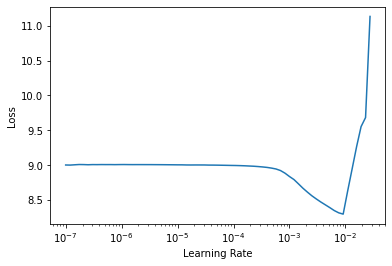

In [52]:
learn = Learner(dls, ReformerLM(vocab_sz, 256, depth=2), metrics=[accuracy, Perplexity()], 
                loss_func=CrossEntropyLossFlat(), path=path, wd=0.1).to_native_fp16()
learn.lr_find()

In [53]:
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.438759,6.000758,0.090703,403.734772,00:07
1,5.544880,5.518611,0.133194,249.288635,00:07
2,5.198312,5.317602,0.148290,203.894287,00:07
3,4.949385,5.265206,0.153843,193.486130,00:06
4,4.753153,5.268610,0.154512,194.145828,00:06
